In [1]:
from preamble import *

2025-01-20 17:02:59,482 - WARNING - File .dacerc not found. You are requesting data in public mode. To change this behaviour, create a .dacerc file in your home directory and fill it with your API key. More infos on https://dace.unige.ch


  0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
for direction in ['Forward','Reverse']:
    F21_wave = NRES_Spectra['F21'][f'{direction}']['w']
    F21_flux = NRES_Spectra['F21'][f'{direction}']['f']
    F21_err = NRES_Spectra['F21'][f'{direction}']['e']

    S22_wave = NRES_Spectra['S22'][f'{direction}']['w']
    S22_flux = NRES_Spectra['S22'][f'{direction}']['f']
    S22_err = NRES_Spectra['S22'][f'{direction}']['e']

NameError: name 'NRES_Spectra' is not defined

In [ ]:
def residual(parameters, data_wave_1, data_flux_1, data_err_1,
             data_wave_2, data_flux_2, data_err_2,
             data_wave_3, data_flux_3, data_err_3,
             data_wave_4, data_flux_4, data_err_4):
    
    G141_model = spectral_model(parameters, 14*u.pixel)
    G102_model = spectral_model(parameters, 5*u.pixel)
    
    # Bin the model to the first data wavelengths
    binned_model_1 = bintogrid(btsettl_wavelengths, G141_model, newx=data_wave_1.value)
    model_flux_1 = binned_model_1['y'] * u.erg / u.s / u.angstrom / u.cm / u.cm
    
    binned_model_2 = bintogrid(btsettl_wavelengths, G141_model, newx=data_wave_2.value)
    model_flux_2 = binned_model_2['y'] * u.erg / u.s / u.angstrom / u.cm / u.cm
    
    binned_model_3 = bintogrid(btsettl_wavelengths, G102_model, newx=data_wave_3.value)
    model_flux_3 = binned_model_3['y'] * u.erg / u.s / u.angstrom / u.cm / u.cm
    
    binned_model_4 = bintogrid(btsettl_wavelengths, G102_model, newx=data_wave_4.value)
    model_flux_4 = binned_model_4['y'] * u.erg / u.s / u.angstrom / u.cm / u.cm
    
    # Calculate residuals for both directions
    residual_1 = (data_flux_1 - model_flux_1) / data_err_1
    residual_2 = (data_flux_2 - model_flux_2) / data_err_2
    residual_3 = (data_flux_3 - model_flux_3) / data_err_3
    residual_4 = (data_flux_4 - model_flux_4) / data_err_4
    
    # Combine the residuals
    combined_residual = np.concatenate([residual_1, residual_2, residual_3, residual_4])
    
    return combined_residual

# 1T BT-SETTL Modeling

In [ ]:
# Define the log-probability function to include both scan directions
def log_probability(parameters, data_wave_1, data_flux_1, data_err_1,
                    data_wave_2, data_flux_2, data_err_2,
                    data_wave_3, data_flux_3, data_err_3,
                    data_wave_4, data_flux_4, data_err_4):
    # Unpack parameters
    T_phot, R_star = parameters
    log_likelihood = 0
    
    # Boundary conditions for parameters to ensure physical validity
    if not (1800 <= T_phot <= 8000 and 0.5 <= R_star <= 0.90):
        return -np.inf  # Return log-probability of -inf outside bounds

    # Set parameters in lmfit
    model_params = lmfit.Parameters()
    model_params.add('T_phot', value=T_phot)
    model_params.add('R_star', value=R_star)

    # Generate model based on these parameters for both scan directions
    model_flux_1 = bintogrid(btsettl_wavelengths, spectral_model(model_params, 14*u.pixel), newx=data_wave_1.value)['y']
    model_flux_2 = bintogrid(btsettl_wavelengths, spectral_model(model_params, 14*u.pixel), newx=data_wave_2.value)['y']
    model_flux_3 = bintogrid(btsettl_wavelengths, spectral_model(model_params, 5*u.pixel), newx=data_wave_3.value)['y']
    model_flux_4 = bintogrid(btsettl_wavelengths, spectral_model(model_params, 5*u.pixel), newx=data_wave_4.value)['y']
    
    # Calculate residuals and log-likelihood for both directions
    residuals_1 = data_flux_1.value - model_flux_1
    residuals_2 = data_flux_2.value - model_flux_2
    residuals_3 = data_flux_3.value - model_flux_3
    residuals_4 = data_flux_4.value - model_flux_4
    
    ln_like_1 = -0.5 * np.nansum((residuals_1 / data_err_1.value) ** 2)
    ln_like_2 = -0.5 * np.nansum((residuals_2 / data_err_2.value) ** 2)
    ln_like_3 = -0.5 * np.nansum((residuals_3 / data_err_3.value) ** 2)
    ln_like_4 = -0.5 * np.nansum((residuals_4 / data_err_4.value) ** 2)
    
    log_likelihood += (ln_like_1 + ln_like_2 + ln_like_3 + ln_like_4)

    
    return log_likelihood

# Collect all visit data for plotting
all_data = {
    'visit': [],
    'direction': [],
    'wavelength': [],
    'calibrated_flux': [],
    'calibrated_flux_err': [],
    'model_flux': [],
    'residuals': []
}
results_table = []

"""
SET PARAMETERS FOR LABELS AND FILESAVING
"""
ncomponents = 1
speclibrary = 'btsettl'
spectral_model = btsettl_1T
nwalkers = 100
nsteps = 1000

data_wave_list = []
data_flux_list = []
data_err_list = []

for visit in ['F21', 'S22']:
    print(f"Processing {visit} (both directions)\n")
    
    # Prepare data for both directions
    exptime = visits[f'{visit}']['exp (s)']
    binwidth = visits[f'{visit}']['native resolution']
    grism = visits[f'{visit}']['Grism']
    filter_sigma = visits[f'{visit}']['filter_sigma']

    trimmed_r_fwd = read_rainbow(f"../data/{visit}_Forward_trimmed_pacman_spec.rainbow.npy")
    trimmed_r_rev = read_rainbow(f"../data/{visit}_Reverse_trimmed_pacman_spec.rainbow.npy")
    
    # Process forward direction data
    median_spectrum_fwd = trimmed_r_fwd.get_median_spectrum().value
    e_per_s_fwd = median_spectrum_fwd / exptime
    e_per_s_per_angstrom_fwd = e_per_s_fwd / binwidth
    w_fwd, s_fwd, e_fwd = read_sensitivity_curve(grism=grism)
    binned_filter_response_fwd = bintogrid(w_fwd.value, s_fwd.value, newx=trimmed_r_fwd.wavelength.value)['y'] * u.cm**2 / u.erg
    calibrated_data_flux_fwd = e_per_s_per_angstrom_fwd / binned_filter_response_fwd
    calibrated_flux_err_fwd = 0.009 * calibrated_data_flux_fwd

    # Append forward direction data to the lists
    data_wave_list.append(trimmed_r_fwd.wavelength)
    data_flux_list.append(calibrated_data_flux_fwd)
    data_err_list.append(calibrated_flux_err_fwd)

    # Process reverse direction data
    median_spectrum_rev = trimmed_r_rev.get_median_spectrum().value
    e_per_s_rev = median_spectrum_rev / exptime
    e_per_s_per_angstrom_rev = e_per_s_rev / binwidth
    w_rev, s_rev, e_rev = read_sensitivity_curve(grism=grism)
    binned_filter_response_rev = bintogrid(w_rev.value, s_rev.value, newx=trimmed_r_rev.wavelength.value)['y'] * u.cm**2 / u.erg
    calibrated_data_flux_rev = e_per_s_per_angstrom_rev / binned_filter_response_rev
    calibrated_flux_err_rev = 0.009 * calibrated_data_flux_rev

    # Append reverse direction data to the lists
    data_wave_list.append(trimmed_r_rev.wavelength)
    data_flux_list.append(calibrated_data_flux_rev)
    data_err_list.append(calibrated_flux_err_rev)

In [ ]:
# Set up lmfit parameters
parameters = lmfit.Parameters()
parameters.add('T_phot', value=4000, min=3000, max=8000, vary=True)
parameters.add('R_star', value=0.78, min=0.5, max=0.90, vary=True)

# Unpack the data lists and run the lmfit minimizer
result = lmfit.minimize(
    residual, 
    parameters, 
    args=(
        data_wave_list[0], data_flux_list[0], data_err_list[0],
        data_wave_list[1], data_flux_list[1], data_err_list[1],
        data_wave_list[2], data_flux_list[2], data_err_list[2],
        data_wave_list[3], data_flux_list[3], data_err_list[3]
    )
)

# Print and log the results as previously done
print("Minimization Results for all datasets:")
for param_name, param in result.params.items():
    print(f"{param_name}: Value = {param.value:.2f}, 1-sigma = {param.stderr if param.stderr else 'N/A'}")

chi_squared = result.chisqr
reduced_chi_squared = result.redchi
dof = result.nfree  # Degrees of freedom
print(f"Chi-squared: {chi_squared:.2f}")
print(f"Reduced Chi-squared: {reduced_chi_squared:.2f}")
print(f"Degrees of freedom: {dof}\n")

# Append minimization results to the table
results_entry = {
    'Chi-squared': chi_squared,
    'Reduced Chi-squared': reduced_chi_squared
}

for param_name, param in result.params.items():
    results_entry[f'{param_name} (Value)'] = param.value
    results_entry[f'{param_name} (1-sigma)'] = param.stderr if param.stderr else 'N/A'
results_table.append(results_entry)

# Store data for plotting across all datasets
for i in range(len(data_wave_list)):
    all_data['visit'].append(f"Visit {i // 2 + 1}")
    all_data['direction'].append('Forward' if i % 2 == 0 else 'Reverse')
    all_data['wavelength'].append(data_wave_list[i].value)
    all_data['calibrated_flux'].append(data_flux_list[i].value)
    all_data['calibrated_flux_err'].append(data_err_list[i].value)

# MCMC setup
ndim = len(result.params)
burnin = int(0.5 * nsteps)
initial_pos = [
    np.array([result.params[name].value for name in result.params]) + 1e-4 * np.random.randn(ndim) 
    for _ in range(nwalkers)
]
print(initial_pos.shape)
label = f'all_visits_{nsteps}steps_{ncomponents}T_{speclibrary}_specmodel'
samples_fname = f"../data/samples/{label}.h5"
backend = emcee.backends.HDFBackend(samples_fname)
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, 
    args=(
        data_wave_list[0], data_flux_list[0], data_err_list[0],
        data_wave_list[1], data_flux_list[1], data_err_list[1],
        data_wave_list[2], data_flux_list[2], data_err_list[2],
        data_wave_list[3], data_flux_list[3], data_err_list[3]
    ),
    backend=backend
)

# Run the MCMC sampler
print('Running MCMC sampler...')
sampler.run_mcmc(initial_pos, nsteps, store=True, progress=True)
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)).T

# Check for convergence (all should be > 100)
for i in range(len(samples)):
    tau_f = emcee.autocorr.integrated_time(samples[i])
    print('(Nsteps-burnin)*nwalkers/tau=', (nsteps-burnin)*nwalkers/tau_f)

# Make corner plot
rng = 0.9995
fig = corner.corner(
    samples.T, show_titles=True, labels=['T_phot', 'R_star'],
    range=[rng] * ndim, smooth=1, quantiles=(0.16, 0.5, 0.84),
    fill_contours=True, plot_datapoints=False, title_kwargs={"fontsize": 15}, title_fmt='.3f',
    hist_kwargs={"linewidth": 2.5}, levels=[(1 - np.exp(-0.5)), (1 - np.exp(-2)), (1 - np.exp(-4.5))]
)
plt.suptitle("MCMC Results for All Datasets")
plt.savefig(f'../figs/all_visits_{nsteps}nsteps_{ncomponents}T_{speclibrary}_specmodel_corner.png')
plt.show()

# Calculate best-fit model flux from MCMC results
T_phot_sam, R_star_sam = samples
sig1_T_phot = np.percentile(T_phot_sam, [15.9, 50., 84.1])  # Central 1-sigma values
sig1_R_star = np.percentile(R_star_sam, [15.9, 50., 84.1])

# Print the 50th percentile (median) and 1-sigma uncertainties for each parameter
print("T_phot:")
print(f"  Median (50th percentile): {sig1_T_phot[1]:.2f}")
print(f"  Lower 1-sigma uncertainty: {sig1_T_phot[1] - sig1_T_phot[0]:.1f}")
print(f"  Upper 1-sigma uncertainty: {sig1_T_phot[2] - sig1_T_phot[1]:.1f}")
print("\nR_star:")
print(f"  Median (50th percentile): {sig1_R_star[1]:.2f}")
print(f"  Lower 1-sigma uncertainty: {sig1_R_star[1] - sig1_R_star[0]:.3f}")
print(f"  Upper 1-sigma uncertainty: {sig1_R_star[2] - sig1_R_star[1]:.3f}")

# Set parameters in lmfit for final model
mcmc_model_params = lmfit.Parameters()
mcmc_model_params.add('T_phot', value=sig1_T_phot[1])
mcmc_model_params.add('R_star', value=sig1_R_star[1])

# Calculate the max likelihood model for all datasets
best_model = spectral_model(mcmc_model_params, filter_sigma)

# Generate binned model fluxes for all datasets and calculate residuals
for i in range(len(data_wave_list)):
    model_flux = bintogrid(btsettl_wavelengths, best_model, newx=data_wave_list[i].value)['y']
    residuals = data_flux_list[i].value - model_flux
    
    # Append residuals and model flux for plotting
    all_data['model_flux'].append(model_flux)
    all_data['residuals'].append(residuals)

# Calculate combined chi-squared and reduced chi-squared
combined_residuals = np.concatenate([
    (data_flux_list[i].value - bintogrid(btsettl_wavelengths, best_model, newx=data_wave_list[i].value)['y']) / data_err_list[i].value
    for i in range(len(data_wave_list))
])
chisq_combined = np.nansum(combined_residuals ** 2)
total_data_points = sum(len(data_flux_list[i]) for i in range(len(data_flux_list)))
dof_combined = total_data_points - len(mcmc_model_params)

# Calculate reduced chi-squared
reduced_chisq_combined = chisq_combined / dof_combined

# Print combined chi-squared statistics
print(f"Combined Chi-squared: {chisq_combined:.2f}")
print(f"Combined Reduced Chi-squared: {reduced_chisq_combined:.2f}")
print(f"Combined Degrees of Freedom: {dof_combined}\n")

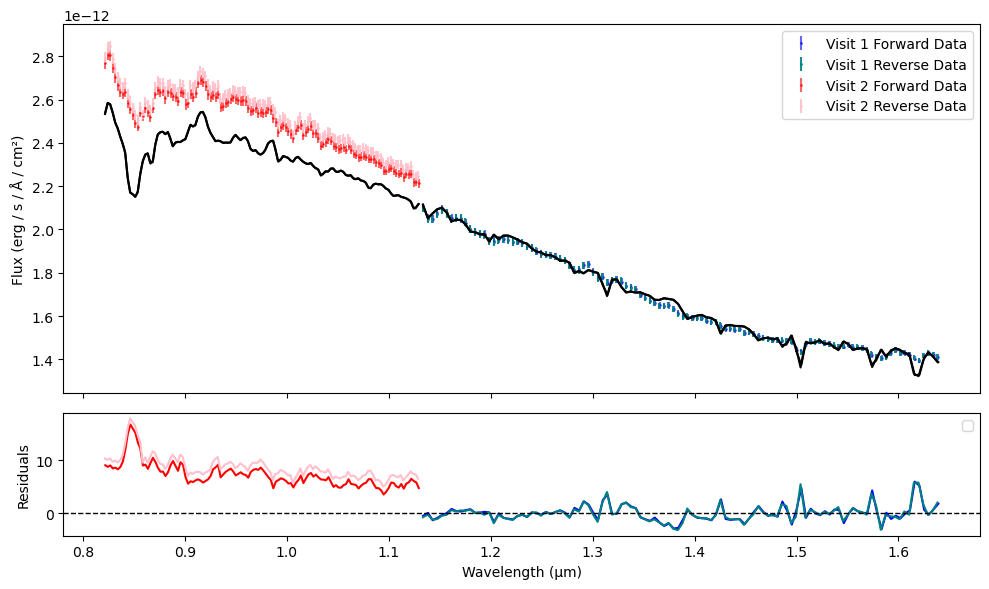

In [57]:
# Plot all data, models, and residuals on a single plot
fig, (ax, ax_residuals) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(10, 6), sharex=True)
colors = ['blue', 'teal', 'red', 'pink']
alphas = [0.6, 1.0, 0.6, 0.9]

for i, (visit, direction, wavelength, data_flux, data_err, model_flux, residual) in enumerate(zip(
    all_data['visit'], all_data['direction'], all_data['wavelength'], all_data['calibrated_flux'], 
    all_data['calibrated_flux_err'], all_data['model_flux'], all_data['residuals'])):
    
    color = colors[i % len(colors)]
    ax.errorbar(wavelength, data_flux, yerr=data_err, fmt='o', color=color, ms=1, label=f'{visit} {direction} Data', alpha=alphas[i])
    ax.plot(wavelength, model_flux, color='k',zorder=1000)
    ax_residuals.plot(wavelength, residual / data_err, color=color)

# Plot configuration
ax.set_ylabel('Flux (erg / s / Å / cm²)')
ax.legend()
ax_residuals.axhline(0, color='black', linestyle='--', linewidth=1)
ax_residuals.set_ylabel('Residuals')
ax_residuals.set_xlabel('Wavelength (μm)')
ax_residuals.legend()

plt.tight_layout()
plt.savefig(f'../figs/{ncomponents}T_{speclibrary}_spectral_resultsplot.png')
plt.show()